In [1]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
Netflix = data.DataReader("NFLX", data_source="yahoo", start = "2002-05-01", end = "2019-06-01")
Netflix.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-05-23,1.242857,1.145714,1.156429,1.196429,104790000.0,1.196429
2002-05-24,1.225000,1.197143,1.214286,1.210000,11104800.0,1.210000
2002-05-28,1.232143,1.157143,1.213571,1.157143,6609400.0,1.157143
2002-05-29,1.164286,1.085714,1.164286,1.103571,6757800.0,1.103571
2002-05-30,1.107857,1.071429,1.107857,1.071429,10154200.0,1.071429


In [3]:
Netflix.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-05-20,352.420013,345.399994,351.230011,348.109985,4621500.0,348.109985
2019-05-21,356.429993,349.929993,350.950012,354.269989,4026400.0,354.269989
2019-05-22,370.459991,357.299988,358.010010,359.730011,6229400.0,359.730011
2019-05-23,357.420013,347.700012,355.500000,352.209991,5630400.0,352.209991
2019-05-24,359.440002,353.790009,355.410004,354.390015,3827400.0,354.390015


In [4]:
Netflix.shape

(4281, 6)

In [5]:
Netflix_train = Netflix.iloc[:4100, :]
Netflix_train.shape

(4100, 6)

In [6]:
Netflix_test = Netflix.iloc[4100:, :]
Netflix_test.shape

(181, 6)

In [7]:
training_set = Netflix.iloc[:4100, 2:3].values
training_set

array([[  1.15642858],
       [  1.21428573],
       [  1.21357143],
       ...,
       [365.        ],
       [370.66000366],
       [366.47000122]])

In [8]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, 4099):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [9]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


# Fitting the RNN to the Training set using Keras Callbacks
es = EarlyStopping(monitor='loss', mode='min', min_delta=1e-10, patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')
history = regressor.fit(X_train, y_train, shuffle=True, epochs = 50, callbacks=[es, rlr,mcp, tb],batch_size = 32)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\Christy\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Instructions for updating:
Use tf.cast instead.
Epoch 1/50
4039/4039 [==============================] - 44s 11ms/step - loss: 0.0039

Epoch 00001: loss improved from inf to 0.00395, saving model to weights.h5
Epoch 2/50
4039/4039 [==============================] - 37s 9ms/step - loss: 9.9120e-04

Epoch 00002: loss improved from 0.00395 to 0.00099, saving model to weights.h5
Epoch 3/50
4039/4039 [==============================] - 36s 9ms/step - loss: 9.3464e-04

Epoch 00003: loss improved from 0.00099 to 0.00093, saving model to weights.h5
Epoch 4/50
4039/4039 [==============================] - 37s 9ms/step - loss: 6.7138e-04

Epoch 00004: loss improved from 0.00093 to 0.00067, saving model to weights.h5
Epoch 5/50
4039/4039 [==============================] - 36s 9ms/step - loss: 7.4481e-04

Epoch 00005: loss did not improve from 0.00067
Epoch 6/50
4039/4039 [==============================] - 36s 9ms/step - loss: 8.3207e-04

Epoch 00006: loss did not improve from 0.00067
Epoch 7/50
4039

In [10]:
# Part 3 - Making the predictions and visualising the results

# Getting the real recent stock price until May 2019
real_stock_price = Netflix_test.iloc[:, 2:3].values

In [11]:
# Getting the predicted stock price until May 2019
Netflix_total = pd.concat((Netflix_train['Close'], Netflix_test['Close']), axis = 0)
inputs = Netflix_total[len(Netflix_total) - len(Netflix_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 241):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

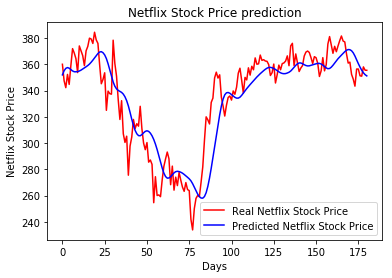

In [12]:
# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Netflix Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Netflix Stock Price')
plt.title('Netflix Stock Price prediction')
plt.xlabel('Days')
plt.ylabel('Netflix Stock Price')
plt.legend()
plt.show()

In [13]:
#Evaluating the RNN
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
rmse

18.07281415765894

In [14]:
min_val=min(real_stock_price)
max_val=max(real_stock_price)
print ("relative error: ", rmse/(max_val-min_val))

relative error:  [0.12011706]


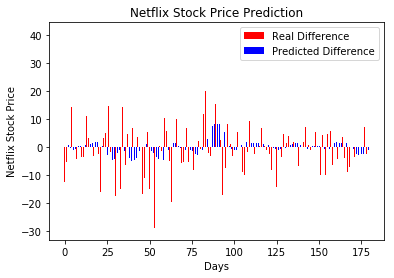

In [15]:
# Visualising the results
 
shift_pred= predicted_stock_price[:-1]
shift_pred = np.append(0, np.reshape(shift_pred, len(shift_pred)))
shift_real = real_stock_price[:-1]
shift_real = np.append(0, np.reshape(shift_real, len(shift_real)))
 
dif_pred = np.add(np.reshape(predicted_stock_price, len(predicted_stock_price)), - shift_pred)[1:]
dif_real = np.add(np.reshape(real_stock_price, len(real_stock_price)), - shift_real)[1:]
 
fig, ax = plt.subplots()
ind = np.arange(dif_real.size)
real_bar = ax.bar(ind-0.15, dif_real, width=0.3, color = 'red', label = 'Real Difference')
pred_bar = ax.bar(ind+0.15, dif_pred, width=0.3, color = 'blue', label = 'Predicted Difference')
ax.set_title('Netflix Stock Price Prediction')
ax.set_xlabel('Days')
ax.set_ylabel('Netflix Stock Price')
ax.legend()
plt.show()